## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df=pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
(df.query('landing_page == "new_page"')['group']=='control').sum()+(df.query('landing_page == "old_page"')['group']=='treatment').sum()

3893

f. Do any of the rows have missing values?

In [7]:
df.isnull().any(axis=1).sum()

0

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
df2 = df.drop(df[(df.group =='treatment') & (df.landing_page =='old_page')].index)
df2 = df2.drop(df2[(df2.group =='control') & (df2.landing_page =='new_page')].index)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
dups = df2[df2.user_id.duplicated(keep=False)]
dups

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2.drop([2893],inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290584 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290584 non-null int64
timestamp       290584 non-null object
group           290584 non-null object
landing_page    290584 non-null object
converted       290584 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [14]:
#b=control    a=convereted
(df2.query('group == "control"')['converted']==1).mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [15]:
#b=treatment     a=converted
(df2.query('group == "treatment"')['converted']==1).mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [16]:
(df2.query('landing_page == "new_page"')).shape[0]/df2.shape[0]

0.5000619442226688

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**Looking just at these few statistics, I think it is unlikely that the old_page/new_page had an effect on whether the customer converted or not. I don't believe a 0.16% difference in the conversion rate is significant.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**The Null Hypothesis is that the old page is the same, if not better.
The Alternative Hypothesis is that the new page is better.**

H0: p(old) >= p(new)

H1: p(new) > p(old)

Or,

H0: p(new) - p(old) <= 0

H1: p(new) - p(old) > 0

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [17]:
new_page_convert = df2.converted.mean()
new_page_convert

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [18]:
old_page_convert = df2.converted.mean()
old_page_convert

0.11959708724499628

c. What is $n_{new}$?

In [19]:
count_new = df2.query('landing_page == "new_page"').count()
count_new

user_id         145310
timestamp       145310
group           145310
landing_page    145310
converted       145310
dtype: int64

d. What is $n_{old}$?

In [20]:
count_old = df2.query('landing_page == "old_page"').count()
count_old

user_id         145274
timestamp       145274
group           145274
landing_page    145274
converted       145274
dtype: int64

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [21]:
new_page_converted = np.random.binomial(1,new_page_convert,count_new[0])
new_page_converted

array([0, 1, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [22]:
old_page_converted = np.random.binomial(1,old_page_convert,count_old[0])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [23]:
obs_diff = new_page_converted.mean()-old_page_converted.mean()
obs_diff

0.00076215069403799685

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [24]:
p_diffs = []

#For loops is slow, based on feedback I will use numpy function instead
#for i in range(10000):
#    p_new = np.random.binomial(1,new_page_convert,count_new[0]).mean()
#    p_old = np.random.binomial(1,old_page_convert,count_old[0]).mean()
#    p_diffs.append(p_new - p_old)
    
new_converted_simulation = np.random.binomial(count_new[0], new_page_convert, 10000)/count_new[0]
old_converted_simulation = np.random.binomial(count_old[0], old_page_convert, 10000)/count_old[0]
p_diffs = new_converted_simulation - old_converted_simulation

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

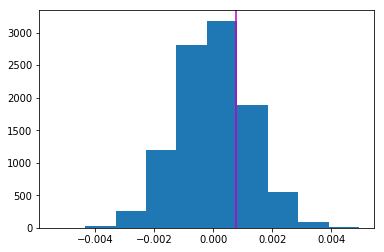

In [39]:
plt.hist(p_diffs);
plt.axvline(obs_diff, color = 'm');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [40]:
actual_new_page_conversion = df2.query('landing_page == "new_page"')['converted'].mean()
actual_old_page_conversion = df2.query('landing_page == "old_page"')['converted'].mean()
p_value = (p_diffs > (actual_new_page_conversion - actual_old_page_conversion)).mean()
p_value

0.90480000000000005

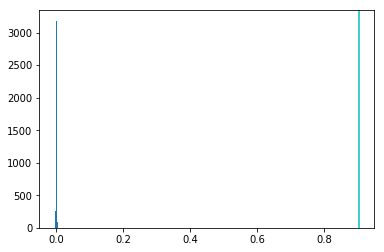

In [41]:
#histogram with p value shaded in bright blue
plt.hist(p_diffs)
plt.axvline(p_value, color = 'c');

**The p-value in this case is so far off to the right, and since this is a one tailed test, we are only looking to see how much data is contained to the *right* of this line. There is essentially none, and so I do not have evidence to suggest that I should reject the null hypothesis.**

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**I computed an observed statistic from the data. I then replicated samples of the data 10,000 times, and found the difference of the means for each of those 10,000 replications. I plotted this observed statistic against a histogram of those 10,000 difference in means to see if the statistic looks like it came from this distribution. The line falls very nicely within the histogram, so I have evidence that this statistic came from the null distribution, and I do not have evidence to suggest I should reject the null hypothesis. **

**This value is called the p value, and since it is greater than our alpha of 0.05, again, I do not have evidence to reject the null hypothesis.** 

**Since I do not have evidence to reject the null hypothesis, this would indicate that, on the surface, the new and the old pages have no difference in conversion rates.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [27]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page"')['converted'].sum()
convert_new = df2.query('landing_page == "new_page"')['converted'].sum()
n_old = df2.query('landing_page == "old_page"').count()
n_new = df2.query('landing_page == "new_page"').count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [28]:
#proportions_ztest(count, nobs, value=None, alternative='two-sided', prop_var=False)
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new],[n_old[0], n_new[0]],alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The p-value calculated in this approach agrees with the p-value I calculated in j and k above, and it is still greater than the given alpha of 0.05, so I would double down on my assertion that I do not have evidence to suggest that I should reject the null hypothesis.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**I'll use logistic regression, which is used to predict only one of two outcomes.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [29]:
df2['intercept'] = 1
df2[['control_page', 'treatment_page']] =  pd.get_dummies(df2['group'])

In [30]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control_page,treatment_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
model = sm.Logit(df2['converted'], df2[['intercept', 'treatment_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:               8.077e-06
Time:                        12:14:57   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9888      0.008   -246.669      0.000      -2.005      -1.973
treatment_page    -0.0150      0.011     -1.311      0.190      -0.037       0.007
==================================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The null hypothesis in this analysis is that there is no relationship between the variables and the conversion rate. And the alternative hypothesis is that there a relationship exists.**

**In this case, the p value is equal to 0.190, and therefore I do not have evidence to suggest that there is a relationship between the page that any given customer is shown and the conversion rate. I do not have evidence to suggest that I should reject the null hypothesis. **

**Why does it differ from the p-value I found in Part II (0.9)? It differs because the null hypothesis I was working with in Part II was that the old page was equal to or *better* than the new page (one tailed test), with the alternative being that the new page was *better*. The null hypothesis I was working with in Part III was that the other variables had no effect on the conversion rate, with the alternative being that there was *some* effect (two tailed test). **

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**You'd like to get a full picture of the data, and how the different variables relate to the conversion rate. It can get cumbersome, and even misleading, especially when there is evidence of multicollinearity.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [35]:
import statsmodels.api as sm

df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [36]:
#create a new DF that includes country data
df3 = pd.merge(df2, df_countries, how='left', on='user_id')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment_page,control_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US


In [37]:
#create dummy variables for country data
df3[['CA','UK','US']] = pd.get_dummies(df3['country'])
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment_page,control_page,country,CA,UK,US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1


In [39]:
#regression to predict conversion rate using ab_page and country data
#using CA as the baseline
model = sm.Logit(df3['converted'],df3[['intercept','treatment_page','US','UK']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:               2.323e-05
Time:                        03:09:13   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -2.0300      0.027    -76.249      0.000      -2.082      -1.978
treatment_page    -0.0149      0.011     -1.307      0.191      -0.037       0.007
US                 0.0408      0.027      1.516      0.130      -0.012       0.093
UK                 0.0506      0.028      1.784      0.074      -0.005       0.106
==================================================================================
"""

In [40]:
#regression to predict conversion rate using ab_page and country data
#this time using UK as the baseline
model = sm.Logit(df3['converted'],df3[['intercept','treatment_page','CA','US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:               2.323e-05
Time:                        03:10:23   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
intercept         -1.9794      0.013   -155.415      0.000      -2.004      -1.954
treatment_page    -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA                -0.0506      0.028     -1.784      0.074      -0.106       0.005
US                -0.0099      0.013     -0.743      0.457      -0.036       0.016
==================================================================================
"""

**It does not appear that the country has an effect on the conversion rate. The Pseudo-R-squared value is essentially zero.  The p-values for CA, US and UK are all greater than alpha (0.05), which would suggest that I do not have evidence to reject the null hypothesis (H0: that they have no effect on the conversion rate).**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [41]:
#create interaction columns
df3['treatment_page_CA'] = df3['treatment_page']*df3['CA']
df3['treatment_page_UK'] = df3['treatment_page']*df3['UK']
df3['treatment_page_US'] = df3['treatment_page']*df3['US']
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,treatment_page,control_page,country,CA,UK,US,treatment_page_CA,treatment_page_UK,treatment_page_US
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,US,0,0,1,0,0,0


In [42]:
#fit the regression model
model = sm.Logit(df3['converted'],df3[['intercept','treatment_page','CA','US','treatment_page_CA', 'treatment_page_US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Fri, 23 Mar 2018   Pseudo R-squ.:               3.482e-05
Time:                        03:18:19   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
intercept            -1.9922      0.016   -123.457      0.000      -2.024      -1.961
treatment_page        0.0108      0.023      0.475      0.635      -0.034       0.056
CA                   -0.0118      0.040     -0.296      0.767      -0.090       0.066
US                    0.0057      0.019      0.306      0.760      -0.031       0.043
treatment_page_CA    -0.0783      0.057     -1.378      0.168      -0.190       0.033
treatment_page_US    -0.0314      0.027     -1.181      0.238      -0.084       0.021
=====================================================================================
"""

**This is now terribly convuluted and difficult to interpret, but I can see that the Psuedo-R-squared value is still essentially zero. Also, all the variable's p-values are greater than my alpha of 0.05. I don't believe adding an interaction between two variables made predicting the conversion rate easier or more reliable.**

<a id='conclusions'></a>
## Conclusions

Congratulations on completing the project! 

### Gather Submission Materials

Once you are satisfied with the status of your Notebook, you should save it in a format that will make it easy for others to read. You can use the __File -> Download as -> HTML (.html)__ menu to save your notebook as an .html file. If you are working locally and get an error about "No module name", then open a terminal and try installing the missing module using `pip install <module_name>` (don't include the "<" or ">" or any words following a period in the module name).

You will submit both your original Notebook and an HTML or PDF copy of the Notebook for review. There is no need for you to include any data files with your submission. If you made reference to other websites, books, and other resources to help you in solving tasks in the project, make sure that you document them. It is recommended that you either add a "Resources" section in a Markdown cell at the end of the Notebook report, or you can include a `readme.txt` file documenting your sources.

### Submit the Project

When you're ready, click on the "Submit Project" button to go to the project submission page. You can submit your files as a .zip archive or you can link to a GitHub repository containing your project files. If you go with GitHub, note that your submission will be a snapshot of the linked repository at time of submission. It is recommended that you keep each project in a separate repository to avoid any potential confusion: if a reviewer gets multiple folders representing multiple projects, there might be confusion regarding what project is to be evaluated.

It can take us up to a week to grade the project, but in most cases it is much faster. You will get an email once your submission has been reviewed. If you are having any problems submitting your project or wish to check on the status of your submission, please email us at dataanalyst-project@udacity.com. In the meantime, you should feel free to continue on with your learning journey by continuing on to the next module in the program.